# Breast Cancer Detection

This notebook investigates automatic breast cancer detection using classical machine learning models and a GRU–SVM hybrid on the Wisconsin Diagnostic Breast Cancer dataset. We follow a full experimental pipeline: exploratory data analysis, careful data preparation, hyperparameter tuning, evaluation on a held-out test set, and learning-curve analysis to support the paper’s conclusions.

In [68]:
# Imports des bibliothèques principales pour la manipulation de données et la visualisation
import pandas as pd        # pd : alias standard pour la bibliothèque pandas (tableaux de données type DataFrame)
import numpy as np         # np : alias standard pour NumPy (calcul numérique, tableaux n-dimensionnels)
import matplotlib.pyplot as plt  # plt : interface de tracé principale de Matplotlib
import seaborn as sns      # sns : bibliothèque de visualisation de haut niveau, basée sur Matplotlib

# Outils de scikit-learn pour découper les données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split

# Outils de prétraitement : standardisation des features et encodage des labels catégoriels
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Modèles linéaires et de type SGD (descente de gradient stochastique)
from sklearn.linear_model import SGDClassifier, SGDRegressor, LogisticRegression

# Support Vector Machines (SVM) pour la classification
from sklearn.svm import SVC

# Réseaux de neurones de type perceptron multicouche (MLP)
from sklearn.neural_network import MLPClassifier

# Méthode des k plus proches voisins (k-NN)
from sklearn.neighbors import KNeighborsClassifier

# Métriques d'évaluation classiques pour la classification et la régression
from sklearn.metrics import (
    confusion_matrix,   # matrice de confusion (TP, TN, FP, FN)
    roc_auc_score,      # aire sous la courbe ROC
    roc_curve,          # points de la courbe ROC (TPR/FPR)
    accuracy_score,     # proportion de prédictions correctes
    recall_score,       # rappel (sensibilité) : proportion de positifs bien détectés
    precision_score,    # précision : proportion de prédictions positives correctes
    f1_score,           # F1-score : moyenne harmonique précision / rappel
    mean_squared_error  # erreur quadratique moyenne (utile pour la régression)
)

# Composants Keras/TensorFlow pour le modèle GRU–SVM
from tensorflow.keras.models import Sequential           # modèle séquentiel (empilement de couches)
from tensorflow.keras.layers import GRU, Dense, Dropout, Input  # couches GRU, denses, dropout et entrée explicite
from tensorflow.keras.callbacks import EarlyStopping      # callback pour arrêter l'entraînement si la val_loss ne s'améliore plus
from tensorflow.keras.optimizers import Adam              # optimiseur Adam (descente de gradient adaptative)
from tensorflow.keras.layers import BatchNormalization    # normalisation de batch pour stabiliser l'entraînement

# Style global des graphiques Seaborn (fond blanc quadrillé pour une meilleure lisibilité)
sns.set_style("whitegrid")

In [69]:
df = pd.read_csv('data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [70]:
print(f"Dataset shape: {df.shape}")
print(f"Features: {df.shape[1] - 1}")
print(f"Samples: {df.shape[0]}")
df.info()

Dataset shape: (569, 33)
Features: 32
Samples: 569
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 

### 1. 📊 Aperçu du Dataset

**Informations clés :**
- 569 samples: Number of tumors analyzed
- 30 features: Measured characteristics (radius, texture, perimeter, etc.)
- 1 target variable: diagnosis (B = Benign, M = Malignant)
- 3 additional columns: id, Unnamed: 32 (empty), diagnosis

Feature structure:
The 30 features are derived from 10 base measurements:
- Mean: features 0-9
- Standard Error: features 10-19
- Worst: features 20-29

In [71]:
missing_count = df.isnull().sum().sum()
print(f"Total missing values: {missing_count}")

Total missing values: 569


In [72]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


### 2. 📐 Structure des Features

Le dataset contient **30 features** dérivées de **10 mesures de base** :
- Mean: features 0-9 - Average value of each characteristic
- Standard Error: features 10-19 - Measurement variability
- Worst: features 20-29 - Most problematic observed value

Example: For cell radius:
- radius_mean: Average radius
- radius_se: Radius standard error
- radius_worst: Largest observed radius

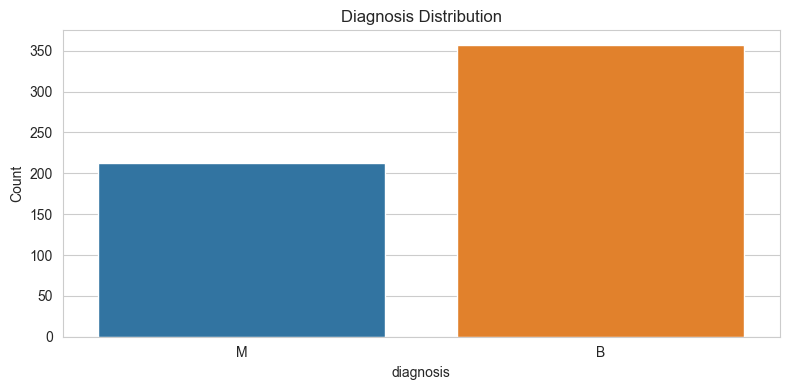

Class distribution:
diagnosis
B    357
M    212
Name: count, dtype: int64
Imbalance ratio: 1.68:1 (Benign:Malignant)


In [73]:
plt.figure(figsize=(8, 4))
diagnosis_counts = df['diagnosis'].value_counts()
sns.countplot(x='diagnosis', data=df, hue='diagnosis', legend=False)
plt.title('Diagnosis Distribution')
plt.ylabel('Count')
plt.tight_layout()
plt.show()
print(f"Class distribution:\n{diagnosis_counts}")
print(f"Imbalance ratio: {diagnosis_counts['B'] / diagnosis_counts['M']:.2f}:1 (Benign:Malignant)")

### 3. 📦 Visualisation des Distributions (Boxplots)

Les boxplots (diagrammes en boîte à moustaches) sont utiles pour :
- Visualize distribution of a numeric variable
- Identify outliers
- Observe median, quartiles (Q1, Q3), and interquartile range (IQR)

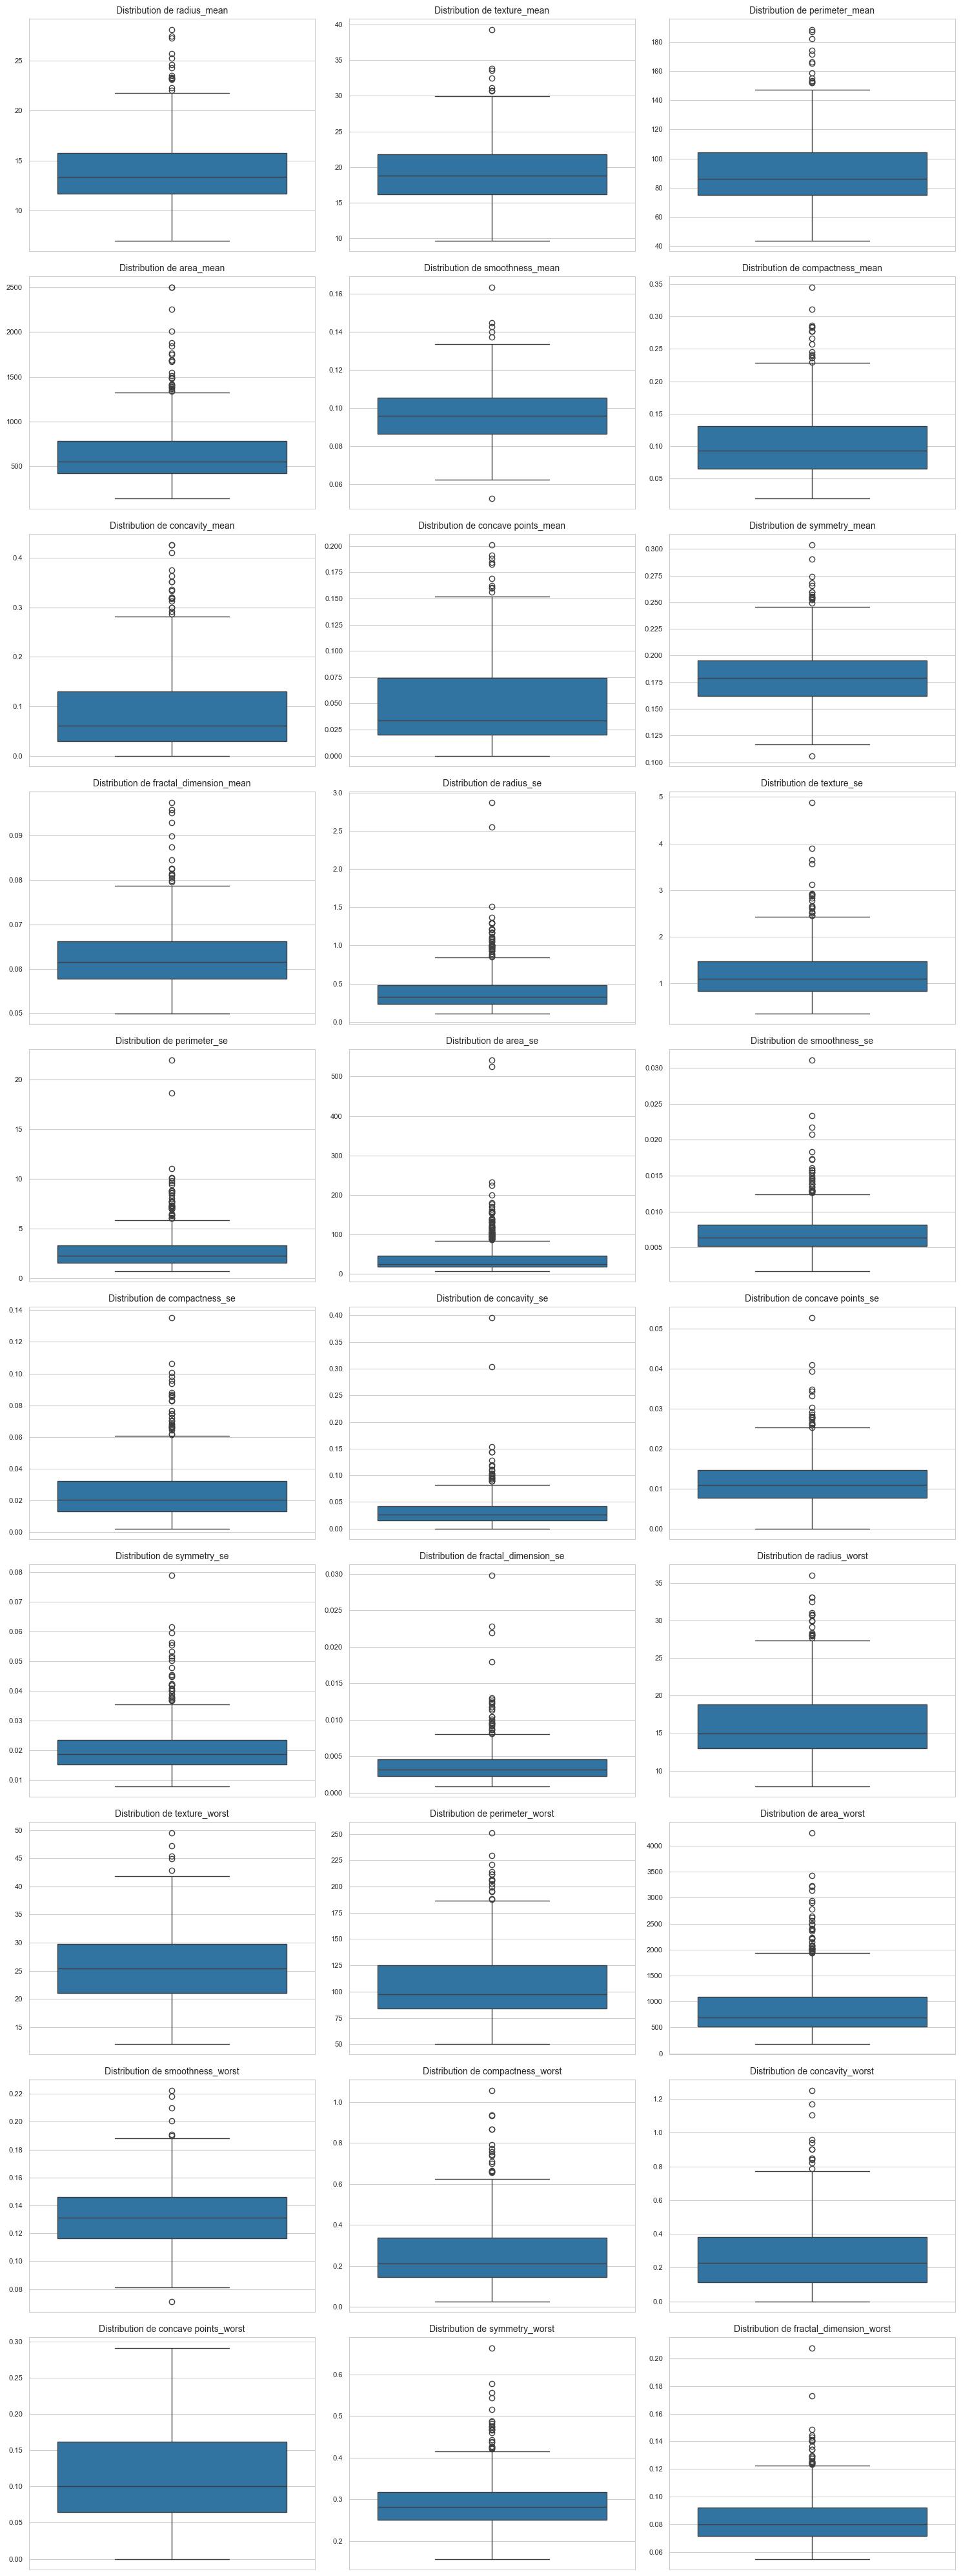

In [74]:
if 'numeric_cols' not in locals():
    numeric_cols = [col for col in df.columns if col not in ['id', 'Unnamed: 32', 'diagnosis']]

n_features = len(numeric_cols)

n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(numeric_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(f'Distribution de {col}', fontsize=10)
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

### 4. 🔗 Analyse de Corrélation

**Pourquoi analyser les corrélations ?**

1. Multicollinearity: Detect highly correlated features (redundant)
   - If two features are highly correlated, remove one
   - Reduces model complexity

2. Understanding relationships: See how features are related
   - Positive correlation: when one feature increases, the other does too
   - Negative correlation: when one increases, the other decreases

3. Feature selection: Identify most important features
   - Features strongly correlated with target = potentially important

Note: High correlations expected since features are derived from same base measurements.

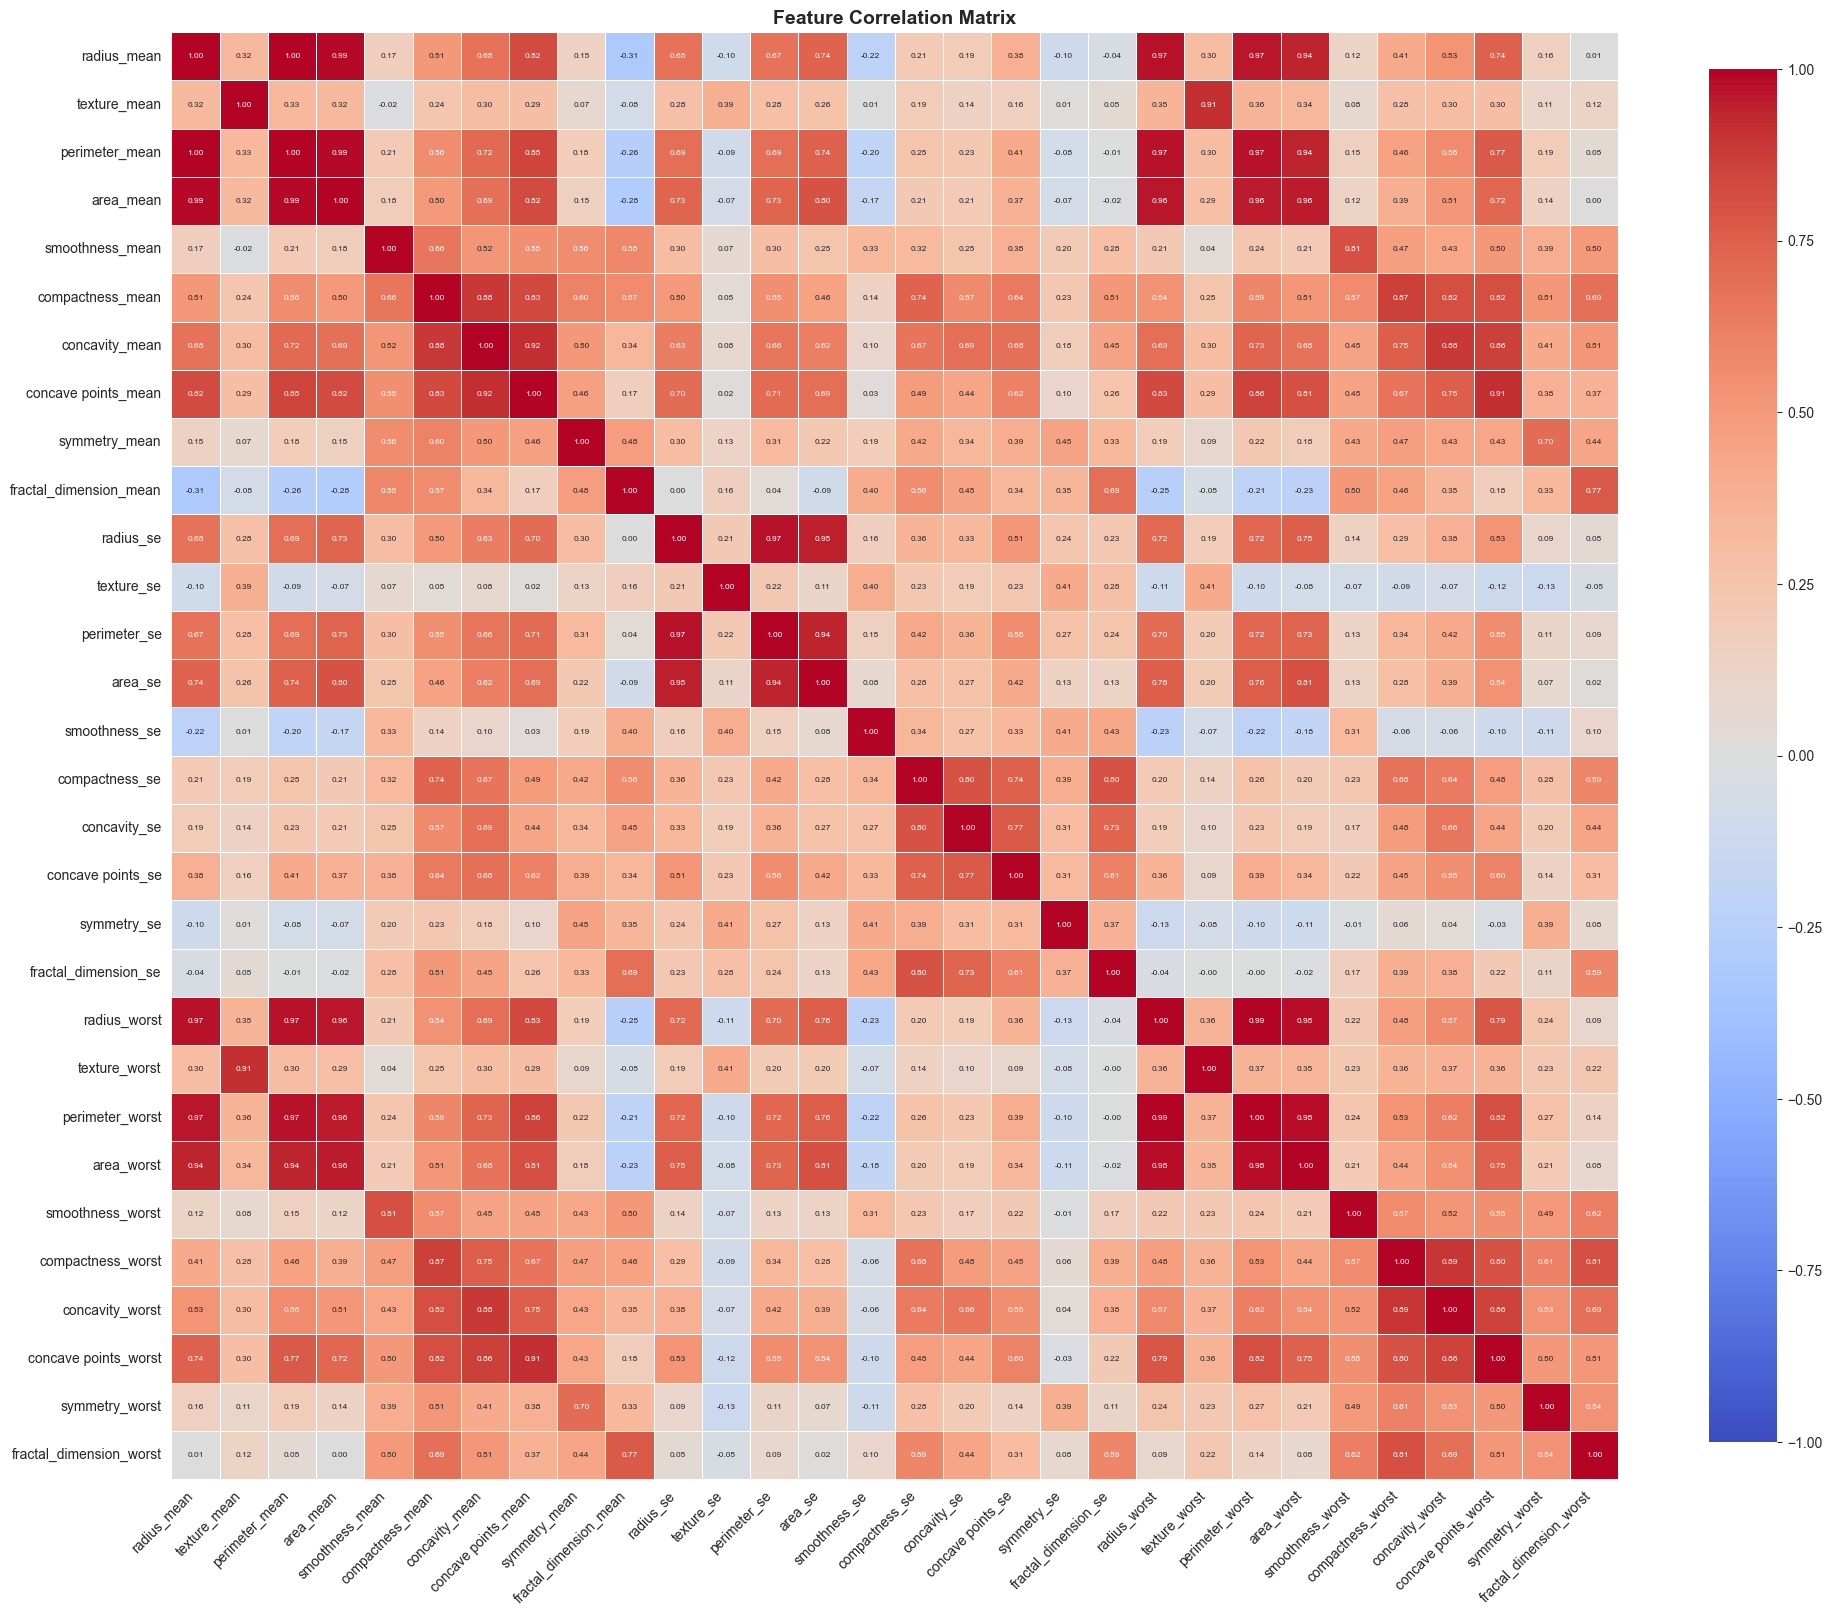

High correlations indicate related features. This is expected as features are derived from the same base measurements.


In [75]:
numeric_cols = [col for col in df.columns if col not in ['id', 'Unnamed: 32', 'diagnosis']]

# Correlation matrix only between feature columns (target removed)
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(20, 18))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8},
    vmin=-1, vmax=1,
    annot_kws={'size': 6},
    linewidths=0.5
)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("High correlations indicate related features. This is expected as features are derived from the same base measurements.")

## 5. Préparation des Données (Data Preparation)

### 5.1 Nettoyage des Données (Data Cleaning)

Justifications for cleaning steps:

1. Remove 'id' column:
   - Unique identifier for each sample
   - No predictive value
   - ML models don't need identifiers

2. Remove 'Unnamed: 32':
   - Empty column
   - Can cause training errors

3. Encode 'diagnosis':
   - ML models need numeric values
   - Convert 'M'/'B' → 1/0
   - Enables mathematical calculations

4. Standardization (Z-score normalization):
   - Why? Features have different scales
     - Example: area_mean ~1000, smoothness_mean ~0.1
   - How? Transform: (x - mean) / std
   - Result: All features have mean=0, std=1
   - Necessary for:
     - SVM: Uses distances, large values would dominate
     - KNN: Distance measurements
     - Neural networks: Faster, stable convergence
     - Linear regression: Prevents feature dominance

In [76]:
# =====================================================================
# Préparation et découpage du jeu de données
# =====================================================================

import numpy as np  # utilisé ici pour compter les exemples par classe avec np.bincount
from sklearn.model_selection import train_test_split  # fonction pour diviser le jeu de données
from sklearn.preprocessing import LabelEncoder, StandardScaler  # encodage des labels et standardisation des features
from imblearn.over_sampling import SMOTE  # SMOTE : sur-échantillonnage synthétique des minoritaires

# ---------------------------------------------------------------------
# 1) Nettoyage des colonnes non pertinentes ou fortement redondantes
# ---------------------------------------------------------------------
# La colonne 'id' est un identifiant unique sans valeur prédictive directe.
# 'Unnamed: 32' est entièrement vide dans ce jeu de données.
# Les colonnes de périmètre/surface très corrélées sont retirées pour réduire la redondance
# et limiter le risque de sur-apprentissage tout en simplifiant les modèles.
df = df.drop([
    'id',             # identifiant inutile pour la prédiction
    'Unnamed: 32',    # colonne vide
    'perimeter_mean', # fortement corrélée avec radius/area
    'perimeter_se',
    'radius_worst',
    'area_mean',
    'perimeter_worst',
    'area_se',
    'area_worst'
], axis=1, errors='ignore')  # errors='ignore' : ne pas lever d'erreur si une colonne n'existe pas

# ---------------------------------------------------------------------
# 2) Encodage de la variable cible (diagnosis) en 0/1
# ---------------------------------------------------------------------
le = LabelEncoder()                     # instancie un encodeur pour transformer les labels catégoriels en entiers
# 'M' (malignant) et 'B' (benign) deviennent typiquement 1 et 0
# fit_transform apprend le mapping puis applique la transformation sur la colonne 'diagnosis'
df['diagnosis'] = le.fit_transform(df['diagnosis'])

# ---------------------------------------------------------------------
# 3) Séparation features / cible
# ---------------------------------------------------------------------
X = df.drop('diagnosis', axis=1)  # X : toutes les colonnes sauf la cible
y = df['diagnosis']               # y : variable cible binaire (0 = bénin, 1 = malin)

# ---------------------------------------------------------------------
# 4) Split entraînement / test (avec stratification)
# ---------------------------------------------------------------------
# test_size=0.3 : 30 % des données pour le test, 70 % pour l'entraînement
# random_state=42 : graine fixe pour rendre le split reproductible
# stratify=y : conserve le même ratio de classes (0/1) dans train et test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Affichage de la taille des ensembles pour vérifier le split
print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Distribution des classes AVANT SMOTE (important pour justifier le rééquilibrage)
print("\nTrain class distribution (before SMOTE):")
print(f"  Benign (0): {np.bincount(y_train)[0]}")   # nombre de cas bénins dans l'entraînement
print(f"  Malignant (1): {np.bincount(y_train)[1]}")  # nombre de cas malins

print("\nTest class distribution:")
print(f"  Benign (0): {np.bincount(y_test)[0]}")
print(f"  Malignant (1): {np.bincount(y_test)[1]}")

# ---------------------------------------------------------------------
# 5) Standardisation des caractéristiques
# ---------------------------------------------------------------------
# StandardScaler met chaque feature à moyenne 0 et écart-type 1, ce qui est crucial
# pour les modèles sensibles à l'échelle (SVM, MLP, k-NN, etc.).
scaler = StandardScaler()

# fit_transform sur X_train : apprend les moyennes/écarts-types puis transforme
X_train_scaled = scaler.fit_transform(X_train)
# transform sur X_test : applique EXACTEMENT la même transformation (pas de fuite d'info)
X_test_scaled = scaler.transform(X_test)

print("\nStandardization applied: mean = 0, std = 1")

# ---------------------------------------------------------------------
# 6) Rééquilibrage des classes avec SMOTE sur l'entraînement
# ---------------------------------------------------------------------
# SMOTE génère de nouveaux exemples synthétiques de la classe minoritaire (ici les malins)
# en interpolant entre voisins proches, afin d'obtenir un jeu de train équilibré.
smote = SMOTE(random_state=42)  # random_state=42 pour rendre l'échantillonnage reproductible

# On applique SMOTE UNIQUEMENT sur X_train_scaled, y_train (jamais sur le test)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("\nTrain class distribution (after SMOTE):")
print(f"  Benign (0): {np.bincount(y_train_smote)[0]}")
print(f"  Malignant (1): {np.bincount(y_train_smote)[1]}")

# ---------------------------------------------------------------------
# 7) Split supplémentaire pour la recherche d'hyperparamètres
# ---------------------------------------------------------------------
# Pour la validation (tuning), on découpe de nouveau X_train_scaled en sous-ensemble d'entraînement
# et de validation, afin d'éviter toute fuite d'information en utilisant le test pour le tuning.
# test_size=0.3 : 30 % de l'ancien train devient validation.
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_scaled,
    y_train,
    test_size=0.3,
    random_state=42
)

# Note: Pour GRU-SVM, on utilisera directement X_train_smote (déjà équilibré avec SMOTE)
# au lieu de créer un second SMOTE sur le sous-ensemble, ce qui est redondant.

Train set: 398 samples (69.9%)
Test set: 171 samples (30.1%)

Train class distribution (before SMOTE):
  Benign (0): 250
  Malignant (1): 148

Test class distribution:
  Benign (0): 107
  Malignant (1): 64

Standardization applied: mean = 0, std = 1

Train class distribution (after SMOTE):
  Benign (0): 250
  Malignant (1): 250


## 6. Modélisation (Modeling)

### 🎯 Objectif
Implement and compare 6 different machine learning algorithms to identify the best classification model.

Algorithms Implemented:

1. Linear Regression (used as classifier)
   - Simple and interpretable model
   - Baseline for comparison

2. Softmax Regression (Logistic Regression)
   - Probabilistic linear classifier
   - Optimized for binary classification

3. Multi-Layer Perceptron (MLP)
   - Deep neural network (3 hidden layers)
   - Captures non-linear patterns

4. Support Vector Machine (L2-SVM)
   - Finds optimal separation boundary
   - RBF kernel for non-linearity

5. K-Nearest Neighbors (KNN)
   - L1 (Manhattan distance) and L2 (Euclidean distance)
   - Classification based on neighbors

6. GRU-SVM (Hybrid model)
   - Deep Learning (GRU) + SVM
   - Most complex architecture

### 6.1 Régression Linéaire (utilisée comme Classifieur)

#### 🎯 Concept
Linear regression is normally used for regression (predicting continuous values), but can be used for binary classification by:
1. Predicting a continuous value (probability)
2. Applying a threshold (0.5) to classify as 0 or 1

Mathematical Formula:
y = w₁x₁ + w₂x₂ + ... + wₙxₙ + b
- w: weights (coefficients) to learn
- x: features
- b: bias (intercept)

Algorithm: SGD (Stochastic Gradient Descent)
- Gradient Descent: Optimizes weights by minimizing error
- Stochastic: Uses random subsample each iteration (faster)
- Advantage: Efficient on large datasets

Chosen Hyperparameters:
- loss='squared_error': Loss function
- learning_rate='constant': Constant learning rate
- eta0=1e-3: Learning rate value (0.001)
- max_iter=3000: Maximum iterations
- random_state=42: For reproducibility

In [77]:
# =====================================================================
# 6.1 Régression linéaire (baseline avec SGDRegressor)
# =====================================================================

# Liste des taux d'apprentissage candidats pour la descente de gradient stochastique.
# 1e-4, 1e-3, 1e-2 : on explore trois ordres de grandeur pour contrôler la taille des pas de mise à jour.
learning_rates = [1e-4, 1e-3, 1e-2]

# Liste des nombres maximum d'itérations (passes sur les données) testés.
# 500, 1000, 2000 : plus le nombre est grand, plus le modèle peut converger finement, mais avec un risque de sur-apprentissage.
iterations = [500, 1000, 2000]

# Meilleure valeur d'AUC observée jusqu'à présent.
# On l'initialise à -inf pour être sûr que la première configuration testée sera retenue.
best_auc_lr = -np.inf

# Hyperparamètres optimaux (taux d'apprentissage et nombre d'itérations) trouvés pendant la recherche.
best_eta = None
best_iter = None

# ---------------------------------------------------------------------
# Boucle de recherche d'hyperparamètres sur (eta0, max_iter)
# ---------------------------------------------------------------------
for eta in learning_rates:           # eta : taux d'apprentissage initial (eta0) testé
    for it in iterations:            # it : nombre maximum d'itérations testé
        # Création d'un modèle de régression linéaire entraîné par SGD
        linear_model = SGDRegressor(
            loss='squared_error',     # fonction de perte : erreur quadratique moyenne (régression linéaire)
            learning_rate='constant', # taux d'apprentissage constant (utilise eta0 à chaque itération)
            eta0=eta,                 # taux d'apprentissage testé dans la boucle
            max_iter=it,              # nombre maximal de passes sur les données
            random_state=42           # graine pour rendre l'entraînement reproductible
        )
        # Entraînement sur le sous-ensemble de train utilisé pour le tuning (sans SMOTE global)
        linear_model.fit(X_train_sub, y_train_sub)

        # Prédiction continue (valeurs réelles entre -inf et +inf) sur la validation
        linear_y_val_continuous = linear_model.predict(X_val)

        # Seuil à 0,5 pour obtenir des prédictions de classe (0 ou 1) à partir des sorties continues
        lr_y_val_pred = (linear_y_val_continuous >= 0.5).astype(int)

        # Import local de MinMaxScaler pour transformer les sorties continues en pseudo‑probabilités dans [0, 1]
        from sklearn.preprocessing import MinMaxScaler
        prob_scaler = MinMaxScaler()  # normalise les valeurs continues sur l'intervalle [0, 1]

        # On ajuste le scaler sur les prédictions d'entraînement pour apprendre le min/max des scores
        linear_y_train_continuous = linear_model.predict(X_train_sub)
        prob_scaler.fit(linear_y_train_continuous.reshape(-1, 1))

        # On transforme ensuite les scores de validation en pseudo‑probabilités entre 0 et 1
        lr_y_val_proba = prob_scaler.transform(
            linear_y_val_continuous.reshape(-1, 1)
        ).flatten()

        # Calcul de l'AUC ROC sur le jeu de validation pour cette configuration (eta, it)
        auc = roc_auc_score(y_val, lr_y_val_proba)

        # Si l'AUC est meilleure que la meilleure actuelle, on met à jour les hyperparamètres optimaux
        if auc > best_auc_lr:
            best_auc_lr = auc   # nouvelle meilleure AUC
            best_eta = eta      # meilleur taux d'apprentissage trouvé
            best_iter = it      # meilleur nombre d'itérations trouvé

# ---------------------------------------------------------------------
# Ré‑entraînement du meilleur modèle sur l'ensemble d'entraînement SMOTE
# ---------------------------------------------------------------------
linear_model = SGDRegressor(
    loss='squared_error',        # même type de perte que pendant le tuning
    learning_rate='constant',    # même stratégie de taux d'apprentissage
    eta0=best_eta,               # taux d'apprentissage optimal trouvé
    max_iter=best_iter,          # nombre d'itérations optimal trouvé
    random_state=42
)

# Entraînement final sur les données d'entraînement rééquilibrées (X_train_smote, y_train_smote)
linear_model.fit(X_train_smote, y_train_smote)

# Prédictions continues sur le jeu de test (valeurs réelles)
linear_y_test_continuous = linear_model.predict(X_test_scaled)

# Conversion en prédictions de classe binaires par seuillage à 0,5
lr_y_test_pred = (linear_y_test_continuous >= 0.5).astype(int)

# Re‑ajustement d'un MinMaxScaler sur les scores continus d'entraînement SMOTE
prob_scaler = MinMaxScaler()
linear_y_train_continuous = linear_model.predict(X_train_smote)
prob_scaler.fit(linear_y_train_continuous.reshape(-1, 1))

# Transformation des scores de test en pseudo‑probabilités dans [0, 1]
lr_y_test_proba = prob_scaler.transform(
    linear_y_test_continuous.reshape(-1, 1)
).flatten()

### 6.2 Régression Softmax (Logistic Regression)

#### 🎯 Concept
La régression softmax (ou régression logistique) est **spécialement conçue pour la classification**.

Mathematical Formula:
P(y=1|x) = 1 / (1 + e^(-z))
where z = w₁x₁ + w₂x₂ + ... + wₙxₙ + b
- Output: Probability directly between 0 and 1 (no normalization needed)
- Sigmoid function: Transforms linear output to probability

Algorithm: Logistic Regression
- Log Loss: Optimal loss function for binary classification
- Formula: -[y*log(ŷ) + (1-y)*log(1-ŷ)]
- Advantage: Strongly penalizes confident errors (predicting 0.9 for class 0)

Hyperparameters:
- C: Inverse regularization strength (0.01 to 100)
- solver: Optimization algorithm ('lbfgs', 'liblinear', 'newton-cg')
- max_iter: Maximum iterations (1000, 3000, 5000)

In [78]:
# =====================================================================
# 6.2 Régression logistique (classifieur Softmax)
# =====================================================================

# Liste de valeurs candidates pour le paramètre de régularisation C.
# C contrôle la pénalisation des poids : petites valeurs = forte régularisation, grandes valeurs = modèle plus flexible.
C_values = [0.1, 1, 10]

# Liste des solveurs pris en charge par scikit-learn pour la régression logistique binaire.
# - 'lbfgs' : quasi-Newton, efficace pour des jeux de données de taille moyenne
# - 'liblinear' : utilise la bibliothèque LIBLINEAR, stable pour des jeux de données petits/moyens
# - 'newton-cg' : variante de Newton conjugué, adaptée au softmax
solvers = ['lbfgs', 'liblinear', 'newton-cg']

# Nombres maximum d'itérations testés pour s'assurer de la convergence.
# Plus max_iter est grand, plus l'optimisation peut converger, au prix d'un temps d'entraînement plus long.
iterations = [1000, 3000, 5000]

# Meilleure AUC observée jusqu'à présent pour la régression logistique.
best_auc_softmax = -np.inf

# Hyperparamètres optimaux retenus : C, solveur et max_iter.
best_softmax_C = None
best_softmax_solver = None
best_softmax_max_iter = None

# ---------------------------------------------------------------------
# Boucle de recherche d'hyperparamètres (C, solver, max_iter)
# ---------------------------------------------------------------------
for C_val in C_values:            # C_val : valeur candidate de C
    for solver in solvers:        # solver : type d'algorithme d'optimisation utilisé
        for it in iterations:     # it : nombre maximal d'itérations
            # Instanciation d'un modèle de régression logistique
            softmax_model = LogisticRegression(
                C=C_val,             # intensité de la régularisation (inverse de lambda)
                solver=solver,       # solveur utilisé pour optimiser la log‑vraisemblance
                max_iter=it,         # borne supérieure sur le nombre d'itérations d'optimisation
                random_state=42      # graine pour la reproductibilité
            )
            # Entraînement sur le sous-ensemble de train pour le tuning
            softmax_model.fit(X_train_sub, y_train_sub)

            # Probabilités prédites pour la classe positive (maligne = 1) sur la validation
            softmax_y_val_proba = softmax_model.predict_proba(X_val)[:, 1]

            # Calcul de l'AUC ROC sur le jeu de validation pour évaluer cette configuration
            auc = roc_auc_score(y_val, softmax_y_val_proba)

            # Mise à jour des meilleurs hyperparamètres si l'AUC est améliorée
            if auc > best_auc_softmax:
                best_auc_softmax = auc       # nouvelle meilleure AUC
                best_softmax_C = C_val       # meilleure valeur de C trouvée
                best_softmax_solver = solver # meilleur solveur trouvé
                best_softmax_max_iter = it   # meilleur nombre d'itérations trouvé

# ---------------------------------------------------------------------
# Ré‑entraînement du meilleur modèle de régression logistique sur SMOTE
# ---------------------------------------------------------------------
softmax_model = LogisticRegression(
    C=best_softmax_C,                # C optimal
    solver=best_softmax_solver,      # solveur optimal
    max_iter=best_softmax_max_iter,  # nombre d'itérations optimal
    random_state=42
)

# Entraînement final sur les données d'entraînement rééquilibrées
softmax_model.fit(X_train_smote, y_train_smote)

# Probabilités prévues pour la classe positive sur le jeu de test
softmax_y_test_proba = softmax_model.predict_proba(X_test_scaled)[:, 1]

# Prédictions de classe (0/1) sur le test en utilisant le seuil par défaut de scikit-learn (0,5)
softmax_y_test_pred = softmax_model.predict(X_test_scaled)

### 6.3 Multi-Layer Perceptron (MLP) - Réseau de Neurones Profond

#### 🎯 Concept
Réseau de neurones artificiels avec **plusieurs couches cachées** pour capturer des patterns non-linéaires complexes.

#### 🏗️ Architecture
Architecture:
Input (30 features)
    ↓
Hidden Layer 1 (50 neurons)
    ↓
Hidden Layer 2 (50 neurons)
    ↓
Hidden Layer 3 (50 neurons)
    ↓
Output (1 neuron, sigmoid)

Functioning:
- Forward propagation: Data flows from input to output
- Backpropagation: Errors propagate back to adjust weights
- ReLU activation: Introduces non-linearity
- Early stopping: Stops if no improvement (prevents overfitting)

Hyperparameters:
- hidden_layer_sizes=(50, 50, 50): 3 layers of 50 neurons each (experimental reduction)
- learning_rate_init=0.005: Initial learning rate = 0.005 (experimental)
- alpha=0.05: L2 regularization (experimental increase)
- early_stopping=True: Early stopping if validation doesn't improve
- validation_fraction=0.1: 10% of training used for validation

In [ ]:
# =====================================================================
# 6.3 MLP (réseau de neurones fully-connected)
# =====================================================================

# Taux d'apprentissage initiaux candidats pour l'optimiseur interne du MLP.
learning_rates = [1e-4, 1e-3]

# Nombres d'itérations maximales (époques) à tester pour l'entraînement du MLP.
iterations = [1000, 3000, 5000]

# Architectures candidates pour les couches cachées :
# - (200, 200) : 2 couches de 200 neurones
# - (500, 500, 500) : 3 couches plus larges de 500 neurones
# - (300, 300, 300) : 3 couches intermédiaires de 300 neurones
hidden_layers = [(200, 200), (500, 500, 500), (300, 300, 300)]

# Valeurs candidates de la régularisation L2 (weight decay) via le paramètre alpha.
# Plus alpha est grand, plus les poids sont pénalisés (modèle plus simple, moins de sur-apprentissage).
alphas = [1e-4, 1e-3, 1e-2, 1e-1]

# Suivi de la meilleure AUC obtenue pendant la recherche d'hyperparamètres.
best_auc_mlp = -np.inf

# Hyperparamètres optimaux retenus pour le MLP.
best_mlp_hidden = None
best_mlp_alpha = None
best_mlp_lr = None
best_mlp_it = None

# ---------------------------------------------------------------------
# Boucle de recherche en grille sur (architecture, alpha, lr, max_iter)
# ---------------------------------------------------------------------
for hls in hidden_layers:          # hls : tuple décrivant la taille de chaque couche cachée
    for alpha in alphas:           # alpha : coefficient de régularisation L2
        for lr in learning_rates:  # lr : learning_rate_init
            for it in iterations:  # it : nombre maximal d'itérations
                # Instanciation du MLP avec un ensemble donné d'hyperparamètres
                mlp_model = MLPClassifier(
                    hidden_layer_sizes=hls,        # architecture des couches cachées testée
                    learning_rate_init=lr,         # taux d'apprentissage initial
                    learning_rate='adaptive',      # le taux s'adapte en fonction de la progression de l'erreur
                    alpha=alpha,                   # pénalisation L2 des poids
                    max_iter=it,                   # nombre maximal d'itérations
                    batch_size=128,                # taille du mini-batch (stabilise les mises à jour)
                    n_iter_no_change=20,           # nombre d'itérations sans amélioration avant arrêt anticipé
                    early_stopping=True,           # active l'arrêt anticipé basé sur la validation interne
                    random_state=42,               # graine pour reproductibilité
                    validation_fraction=0.1        # part de l'entraînement utilisée comme validation interne
                )

                # Entraînement du MLP sur le sous-ensemble de train pour le tuning
                mlp_model.fit(X_train_sub, y_train_sub)

                # Probabilités pour la classe positive sur le jeu de validation externe X_val
                mlp_y_val_proba = mlp_model.predict_proba(X_val)[:, 1]

                # Calcul de l'AUC ROC pour cette configuration d'hyperparamètres
                auc = roc_auc_score(y_val, mlp_y_val_proba)

                # Mise à jour des meilleurs hyperparamètres si l'AUC est améliorée
                if auc > best_auc_mlp:
                    best_auc_mlp = auc
                    best_mlp_hidden = hls
                    best_mlp_alpha = alpha
                    best_mlp_lr = lr
                    best_mlp_it = it

# ---------------------------------------------------------------------
# Ré‑entraînement du MLP avec les meilleurs hyperparamètres sur SMOTE
# ---------------------------------------------------------------------
mlp_model = MLPClassifier(
    hidden_layer_sizes=best_mlp_hidden,  # architecture optimale
    learning_rate_init=best_mlp_lr,      # taux d'apprentissage optimal
    alpha=best_mlp_alpha,                # régularisation L2 optimale
    max_iter=best_mlp_it,                # nombre d'itérations optimal
    early_stopping=True,                 # arrêt anticipé basé sur validation interne
    random_state=42,
    verbose=0,                           # verbose=0 : ne pas afficher les logs d'entraînement
    validation_fraction=0.1
)

# Entraînement final sur les données d'entraînement rééquilibrées
mlp_model.fit(X_train_smote, y_train_smote)

# Probabilités pour la classe positive sur le jeu de test
mlp_y_test_proba = mlp_model.predict_proba(X_test_scaled)[:, 1]

# Prédictions de classe (0/1) sur le jeu de test
mlp_y_test_pred = mlp_model.predict(X_test_scaled)

### 6.4 Support Vector Machine (L2-SVM)

#### 🎯 Concept
Trouve la **meilleure frontière de séparation** (hyperplan) entre les classes en maximisant la marge.

#### 📐 Principe
- **Support Vectors** : Points les plus proches de la frontière
- **Marge** : Distance entre la frontière et les points les plus proches
- RBF Kernel: Transforms data to higher dimension for non-linear separation

Hyperparameters:
- C=5: Regularization parameter
  - Small C: More regularization, simpler boundary
  - Large C: Less regularization, complex boundary (overfitting risk)
- kernel='rbf': Radial Basis Function (Gaussian)
  - Allows non-linear boundaries
  - Formula: K(x,y) = exp(-γ||x-y||²)
- gamma='scale': Auto-calculates γ = 1/(n_features * variance)
- probability=True: Enables probability outputs (uses Platt scaling)

In [80]:
# =====================================================================
# 6.4 L2-SVM (machine à vecteurs de support linéaire)
# =====================================================================

# Valeurs candidates pour le paramètre de régularisation C de la SVM linéaire.
# C élevé -> marge plus petite mais moins d'erreurs d'entraînement ; C faible -> marge plus large mais plus d'erreurs permises.
C_values = [0.1, 1, 10]

# Meilleure AUC obtenue pour la SVM sur la validation.
best_auc_svm = -np.inf

# Meilleure valeur de C retenue.
best_svm_C = None

# ---------------------------------------------------------------------
# Boucle de recherche sur C pour la SVM linéaire
# ---------------------------------------------------------------------
for C in C_values:  # C : intensité de la pénalisation des erreurs
    svm_model = SVC(
        C=C,                  # valeur de C testée
        kernel='linear',      # noyau linéaire : frontière de décision planaire
        probability=True,     # active la calibration des probabilités via Platt scaling
        random_state=42       # graine pour reproductibilité (utile surtout pour le calibrage)
    )
    # Entraînement de la SVM sur le sous-ensemble d'entraînement pour le tuning
    svm_model.fit(X_train_sub, y_train_sub)

    # Probabilités prévues pour la classe positive sur la validation
    svm_y_val_proba = svm_model.predict_proba(X_val)[:, 1]

    # Calcul de l'AUC ROC pour évaluer la qualité de la séparation des classes
    auc = roc_auc_score(y_val, svm_y_val_proba)

    # Mise à jour de la meilleure valeur de C si l'AUC est améliorée
    if auc > best_auc_svm:
        best_auc_svm = auc
        best_svm_C = C

# ---------------------------------------------------------------------
# Ré‑entraînement de la SVM linéaire avec le meilleur C sur SMOTE
# ---------------------------------------------------------------------
svm_model = SVC(
    C=best_svm_C,          # meilleur paramètre C trouvé
    kernel='linear',       # noyau linéaire
    probability=True,
    random_state=42
)

# Entraînement final sur les données d'entraînement rééquilibrées
svm_model.fit(X_train_smote, y_train_smote)

# Prédictions de classe sur le jeu de test
svm_y_test_pred = svm_model.predict(X_test_scaled)

# Probabilités prévues pour la classe positive sur le jeu de test
svm_y_test_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

### 6.5 K-Nearest Neighbors (KNN) - Plus Proches Voisins

#### 🎯 Concept
Classifie un point selon la **majorité des classes** de ses **k plus proches voisins** dans l'espace des features.

#### 📐 Principe
1. Pour un nouvel échantillon, trouve les k échantillons les plus proches
2. Regarde les classes de ces k voisins
3. Assigns the majority class

Distances:
- L1 (Manhattan): d = |x₁-y₁| + |x₂-y₂| + ...
  - "City block" distance
  - More robust to outliers
  
- L2 (Euclidean): d = √[(x₁-y₁)² + (x₂-y₂)² + ...]
  - "As the crow flies" distance
  - More sensitive to large differences

Hyperparameters:
- n_neighbors=1: Uses only the nearest neighbor (1-NN)
  - Advantage: Simple and often effective
  - Disadvantage: Sensitive to noise
- metric='minkowski': Generalized metric
- p=1: L1 distance (Manhattan)
- p=2: L2 distance (Euclidean)

In [81]:
# =====================================================================
# 6.5 k plus proches voisins (L1 et L2)
# =====================================================================

# Ensemble de valeurs k candidates (nombre de voisins) pour les modèles k-NN.
# De petits k (1,3) capturent des structures très locales mais sont plus sensibles au bruit.
# Des k plus grands (7,9) lissent davantage la décision.
k_values = [1, 3, 5, 7, 9]

# Meilleure AUC pour le modèle k-NN avec distance L1 (Manhattan).
best_auc_knn_l1 = -np.inf
best_knn_l1_k = None  # valeur optimale de k pour L1

# Meilleure AUC pour le modèle k-NN avec distance L2 (euclidienne).
best_auc_knn_l2 = -np.inf
best_knn_l2_k = None  # valeur optimale de k pour L2

# ---------------------------------------------------------------------
# Boucle sur les différentes valeurs de k pour L1 et L2
# ---------------------------------------------------------------------
for k in k_values:
    # ------- k-NN avec distance de Manhattan (L1) -------
    knn_l1 = KNeighborsClassifier(
        n_neighbors=k,        # nombre de voisins pris en compte
        metric='minkowski',   # métrique Minkowski générale
        p=1                   # p=1 => distance de Manhattan (L1)
    )
    knn_l1.fit(X_train_sub, y_train_sub)  # entraînement sur le sous-ensemble d'entraînement

    # Probabilités pour la classe positive sur la validation
    knn_l1_y_val_proba = knn_l1.predict_proba(X_val)[:, 1]

    # AUC ROC pour ce k avec distance L1
    auc = roc_auc_score(y_val, knn_l1_y_val_proba)
    if auc > best_auc_knn_l1:
        best_auc_knn_l1 = auc
        best_knn_l1_k = k

    # ------- k-NN avec distance euclidienne (L2) -------
    knn_l2 = KNeighborsClassifier(
        n_neighbors=k,        # même k testé
        metric='minkowski',   # métrique Minkowski
        p=2                   # p=2 => distance euclidienne (L2)
    )
    knn_l2.fit(X_train_sub, y_train_sub)

    # Probabilités pour la classe positive sur la validation
    knn_l2_y_val_proba = knn_l2.predict_proba(X_val)[:, 1]

    # AUC ROC pour ce k avec distance L2
    auc = roc_auc_score(y_val, knn_l2_y_val_proba)
    if auc > best_auc_knn_l2:
        best_auc_knn_l2 = auc
        best_knn_l2_k = k

# ---------------------------------------------------------------------
# Ré‑entraînement des meilleurs modèles k-NN (L1 et L2) sur SMOTE
# ---------------------------------------------------------------------
# Modèle k-NN L1 avec le meilleur k trouvé.
knn_l1 = KNeighborsClassifier(
    n_neighbors=best_knn_l1_k,
    metric='minkowski',
    p=1
)
knn_l1.fit(X_train_smote, y_train_smote)

# Prédictions de classe et probabilités sur le jeu de test
knn_l1_y_test_pred = knn_l1.predict(X_test_scaled)
knn_l1_y_test_proba = knn_l1.predict_proba(X_test_scaled)[:, 1]

# Modèle k-NN L2 avec le meilleur k trouvé.
knn_l2 = KNeighborsClassifier(
    n_neighbors=best_knn_l2_k,
    metric='minkowski',
    p=2
)
knn_l2.fit(X_train_smote, y_train_smote)

# Prédictions de classe et probabilités sur le jeu de test
knn_l2_y_test_pred = knn_l2.predict(X_test_scaled)
knn_l2_y_test_proba = knn_l2.predict_proba(X_test_scaled)[:, 1]

### 6.6 GRU-SVM (Hybrid Model: Deep Learning + SVM)

#### Concept: 2-Step Hybrid Architecture

This model combines two powerful techniques:

1. GRU (Gated Recurrent Unit): Recurrent neural network
   - Extracts complex features (abstract representations)
   - Treats data as temporal sequence
   
2. SVM (Support Vector Machine): Final classifier
   - Uses features extracted by GRU
   - Finds optimal decision boundary

GRU Architecture (optimisée pour réduire l'overfitting):

Input (30 features × 1)
    ↓
GRU Layer (48 units) + L2(0.01)      ← Extracts complex features avec régularisation
    ↓
Dropout (0.5)                        ← Regularization (prevents overfitting)
    ↓
BatchNormalization                    ← Stabilise l'entraînement
    ↓
Dense Layer (24 units, ReLU) + L2(0.01) ← Fully-connected layer avec régularisation
    ↓
Dropout (0.4)                        ← Regularization supplémentaire
    ↓
BatchNormalization                    ← Normalisation supplémentaire
    ↓
Dense Output (1 unit, Sigmoid)       ← Final prediction

Feature extraction: Takes output from Dense(24) layer before dropout and final layer

Why this Architecture?

- GRU: Captures complex patterns in data
- Reduced complexity (48 units vs 128, 24 vs 32): Prevents overfitting
- L2 Regularization: Penalizes large weights → prevents overfitting
- Multiple Dropout layers: Randomly deactivates neurons → prevents overfitting
- BatchNormalization: Stabilizes training and improves generalization
- Final SVM: Uses extracted features for optimal classification

Hyperparameters optimisés (anti-overfitting):

- Cell Size (GRU): 48 units (réduit de 64 pour limiter la complexité)
- L2 Regularization: 0.01 (sur GRU et Dense layers)
- Dropout: 0.5 (après GRU), 0.4 (après Dense)
- BatchNormalization: Après GRU et après Dense
- Batch Size: 64 samples per batch (réduit de 128 pour plus de régularisation)
- Learning Rate: 5e-4 (0.0005, réduit de 1e-3 pour un entraînement plus stable)
- Optimizer: Adam (adaptive)
- Early Stopping: Stops if no improvement for 20 epochs (patience réduite de 30)
- SVM: gamma='scale' pour une meilleure régularisation

In [82]:
# =====================================================================
# 6.6 Hybride GRU–SVM
# =====================================================================

# Valeurs candidates de C pour la SVM à noyau RBF appliquée sur les features extraites par le GRU.
C_values = [0.1, 1, 5]

# Meilleure AUC obtenue pour la combinaison GRU + SVM.
best_auc_gru = -np.inf

# Hyperparamètres/infos retenus pour le meilleur modèle GRU–SVM.
best_gru_units = None   # nombre de neurones GRU (fixé à 64 ici, mais conservé pour la cohérence)
best_gru_svm_C = None   # meilleure valeur de C pour la SVM

# ---------------------------------------------------------------------
# Préparation des entrées pour le GRU
# ---------------------------------------------------------------------
# Nombre de caractéristiques d'entrée (dimensions des vecteurs de features tabulaires).
n_features = X_train_smote.shape[1]

# Reshape des données tabulaires en séquences de longueur n_features avec 1 feature par "time-step".
# Forme attendue par le GRU : (n_samples, timesteps, features_par_timestep)
X_train_gru = X_train_smote.reshape(X_train_smote.shape[0], n_features, 1)
X_val_gru = X_val.reshape(X_val.shape[0], n_features, 1)
X_test_gru = X_test_scaled.reshape(X_test_scaled.shape[0], n_features, 1)

# ---------------------------------------------------------------------
# Définition de l'architecture GRU avec régularisation anti-overfitting
# ---------------------------------------------------------------------
from tensorflow.keras.regularizers import l2

gru_model = Sequential([
    # Couche d'entrée explicitant la forme des séquences d'entrée
    Input(shape=(n_features, 1)),

    # Couche GRU avec 48 unités (réduite de 64) + régularisation L2 pour limiter l'overfitting
    GRU(48, return_sequences=False, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),

    # Dropout 0.5 : éteint aléatoirement 50 % des unités pour limiter le sur-apprentissage
    Dropout(0.5),

    # BatchNormalization : normalise les activations pour stabiliser l'entraînement
    BatchNormalization(),

    # Couche dense intermédiaire de 24 neurones (réduite de 32) avec régularisation L2
    Dense(24, activation='relu', kernel_regularizer=l2(0.01)),

    # Dropout supplémentaire après la couche dense pour plus de régularisation
    Dropout(0.4),

    # BatchNormalization supplémentaire
    BatchNormalization(),

    # Couche de sortie de taille 1 avec sigmoïde : renvoie une probabilité de malignité entre 0 et 1
    Dense(1, activation='sigmoid')
])

# Compilation du modèle GRU
# - Adam : optimiseur adaptatif bien adapté aux réseaux profonds
# - binary_crossentropy : perte standard pour la classification binaire
# - metrics=['accuracy'] : suivre l'accuracy pendant l'entraînement
# - Learning rate réduit à 5e-4 pour un entraînement plus stable et moins d'overfitting
gru_model.compile(
    optimizer=Adam(learning_rate=5e-4),  # taux d'apprentissage réduit pour limiter l'overfitting
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping : arrête l'entraînement si la perte de validation ne s'améliore plus.
# Patience réduite à 20 pour arrêter plus tôt et éviter l'overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',       # on surveille la perte de validation
    patience=20,              # on attend 20 époques sans amélioration avant d'arrêter (réduit de 30)
    restore_best_weights=True,# on restaure les poids correspondant à la meilleure val_loss
    min_delta=1e-4,          # amélioration minimale requise pour considérer une amélioration
    verbose=0
)

# Entraînement du GRU sur les données séquentielles dérivées de X_train_smote
# - epochs=300 : nombre maximal d'époques réduit (l'early stopping arrêtera plus tôt si nécessaire)
# - batch_size=64 : taille du mini-batch réduite pour plus de régularisation
# - validation_split=0.2 : 20 % des données d'entraînement utilisés comme validation interne
# - callbacks=[early_stopping] : applique l'arrêt anticipé décrit ci‑dessus
gru_model.fit(
    X_train_gru, y_train_smote,
    epochs=300,
    batch_size=64,
    validation_split=0.2,
    verbose=0,
    callbacks=[early_stopping]
)

# ---------------------------------------------------------------------
# Extraction des caractéristiques apprises par le GRU
# ---------------------------------------------------------------------
from tensorflow.keras.models import Model

# On définit un modèle intermédiaire qui prend la même entrée que le GRU
# mais dont la sortie est la couche dense de 24 neurones (avant le dropout, la normalisation batch et la sortie sigmoïde).
model_input = gru_model.layers[0].input
feature_extractor = Model(
    inputs=model_input,
    outputs=gru_model.layers[-4].output  # couche Dense(24, activation='relu') - index ajusté pour la nouvelle architecture
)

# Extraction des features pour train / val / test (sorties 24D)
gru_train_features = feature_extractor.predict(X_train_gru, verbose=0)
gru_val_features = feature_extractor.predict(X_val_gru, verbose=0)
gru_test_features = feature_extractor.predict(X_test_gru, verbose=0)

# ---------------------------------------------------------------------
# Recherche du meilleur C pour la SVM RBF sur les features extraites
# ---------------------------------------------------------------------
for C_val in C_values:
    gru_svm_model = SVC(
        kernel='rbf',      # noyau RBF pour capturer des frontières non linéaires dans l'espace des embeddings
        C=C_val,           # valeur de C testée
        gamma='scale',     # gamma='scale' pour une meilleure régularisation (1 / (n_features * X.var()))
        probability=True   # permet d'obtenir des probabilités calibrées
    )
    gru_svm_model.fit(gru_train_features, y_train_smote)

    # Probabilités pour la classe positive sur les embeddings de validation
    gru_svm_y_val_proba = gru_svm_model.predict_proba(gru_val_features)[:, 1]

    # AUC ROC pour cette valeur de C
    auc = roc_auc_score(y_val, gru_svm_y_val_proba)
    if auc > best_auc_gru:
        best_auc_gru = auc
        best_gru_units = 64      # taille de la couche GRU (fixe dans ce notebook)
        best_gru_svm_C = C_val   # meilleure valeur de C pour la SVM

# ---------------------------------------------------------------------
# Entraînement final de la SVM RBF GRU–SVM sur l'ensemble train complet
# ---------------------------------------------------------------------
gru_svm_model = SVC(
    kernel='rbf',
    C=best_gru_svm_C,      # meilleur C trouvé
    gamma='scale',         # gamma='scale' pour une meilleure régularisation et éviter l'overfitting
    probability=True,
    random_state=42
)

# Entraînement de la SVM sur les features GRU extraites du train complet
gru_svm_model.fit(gru_train_features, y_train_smote)

# Prédictions de classe et probabilités sur le jeu de test (dans l'espace des embeddings GRU)
gru_svm_y_test_pred = gru_svm_model.predict(gru_test_features)
gru_svm_y_test_proba = gru_svm_model.predict_proba(gru_test_features)[:, 1]

## 7. Évaluation (Evaluation)

### 🎯 Objectif
Comparer les performances de tous les modèles sur l'ensemble de test en utilisant plusieurs métriques.

### 📊 Métriques Utilisées

1. **Accuracy (Précision)** : Pourcentage de prédictions correctes
2. **ROC-AUC** : Aire sous la courbe ROC (capacité à distinguer les classes)
3. **Recall (Rappel/Sensibilité)** : Capacité à détecter les vrais positifs
4. Precision: Proportion of true positives among positive predictions
5. F1-Score: Harmonic mean of precision and recall
6. Specificity: Ability to detect true negatives
7. FPR (False Positive Rate): False positive rate
8. FNR (False Negative Rate): False negative rate
9. TPR (True Positive Rate): True positive rate (= Recall)

In [83]:
# =====================================================================
# 7. Évaluation : calcul des métriques sur le jeu de test
# =====================================================================

from sklearn.metrics import (
    confusion_matrix, accuracy_score, roc_auc_score,
    recall_score, precision_score, f1_score
)
import pandas as pd

# ---------------------------------------------------------------------
# Fonction utilitaire pour calculer les métriques principales
# ---------------------------------------------------------------------
def calculate_metrics(y_true, y_pred, y_proba):
    """Calcule les métriques de classification binaire à partir des prédictions."""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    return {
        'accuracy': accuracy_score(y_true, y_pred),           # proportion de prédictions correctes
        'roc_auc': roc_auc_score(y_true, y_proba),            # aire sous la courbe ROC
        'recall': recall_score(y_true, y_pred, pos_label=1),  # sensibilité (TP / (TP + FN))
        'precision': precision_score(y_true, y_pred, pos_label=1),  # précision (TP / (TP + FP))
        'f1_score': f1_score(y_true, y_pred, pos_label=1),    # F1-score (moyenne harmonique)
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0.0,  # spécificité (TN / (TN + FP))
        'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0.0,      # taux de faux positifs
        'FNR': fn / (fn + tp) if (fn + tp) > 0 else 0.0,      # taux de faux négatifs
        'TPR': tp / (tp + fn) if (tp + fn) > 0 else 0.0       # taux de vrais positifs (= recall)
    }

# ---------------------------------------------------------------------
# Calcul des métriques pour chaque modèle sur le jeu de test
# ---------------------------------------------------------------------
test_results = {
    'Linear Regression': calculate_metrics(y_test, lr_y_test_pred, lr_y_test_proba),
    'Softmax Regression': calculate_metrics(y_test, softmax_y_test_pred, softmax_y_test_proba),
    'MLP': calculate_metrics(y_test, mlp_y_test_pred, mlp_y_test_proba),
    'L2-SVM': calculate_metrics(y_test, svm_y_test_pred, svm_y_test_proba),
    'L1-NN': calculate_metrics(y_test, knn_l1_y_test_pred, knn_l1_y_test_proba),
    'L2-NN': calculate_metrics(y_test, knn_l2_y_test_pred, knn_l2_y_test_proba),
    'GRU-SVM': calculate_metrics(y_test, gru_svm_y_test_pred, gru_svm_y_test_proba)
}

# Affichage des résultats sous forme de tableau
results_df = pd.DataFrame(test_results).T
print(results_df)

                    accuracy   roc_auc   recall  precision  f1_score  \
Linear Regression   0.947368  0.988026  0.90625   0.950820  0.928000   
Softmax Regression  0.982456  0.997810  0.96875   0.984127  0.976378   
MLP                 0.953216  0.990508  0.93750   0.937500  0.937500   
L2-SVM              0.959064  0.993283  0.90625   0.983051  0.943089   
L1-NN               0.964912  0.995765  0.93750   0.967742  0.952381   
L2-NN               0.970760  0.989048  0.93750   0.983607  0.960000   
GRU-SVM             0.947368  0.978972  0.93750   0.923077  0.930233   

                    specificity       FPR      FNR      TPR  
Linear Regression      0.971963  0.028037  0.09375  0.90625  
Softmax Regression     0.990654  0.009346  0.03125  0.96875  
MLP                    0.962617  0.037383  0.06250  0.93750  
L2-SVM                 0.990654  0.009346  0.09375  0.90625  
L1-NN                  0.981308  0.018692  0.06250  0.93750  
L2-NN                  0.990654  0.009346  0.06250 

### 8. 📊 Matrices de Confusion

**Qu'est-ce qu'une matrice de confusion ?**

Tableau 2×2 qui montre :
- **TN (True Negative)** : Vrais négatifs (bénin prédit bénin) - en haut à gauche
- **FP (False Positive)** : Faux positifs (bénin prédit malin) - en haut à droite
- **FN (False Negative)** : Faux négatifs (malin prédit bénin) - en bas à gauche
- **TP (True Positive)** : Vrais positifs (malin prédit malin) - en bas à droite

Interpretation in medical context:
- FN (False Negatives): CRITICAL - Undetected cancer (very dangerous!)
- FP (False Positives): Less serious - False alarm (but causes stress)
- Goal: Minimize FN (don't miss cancers)

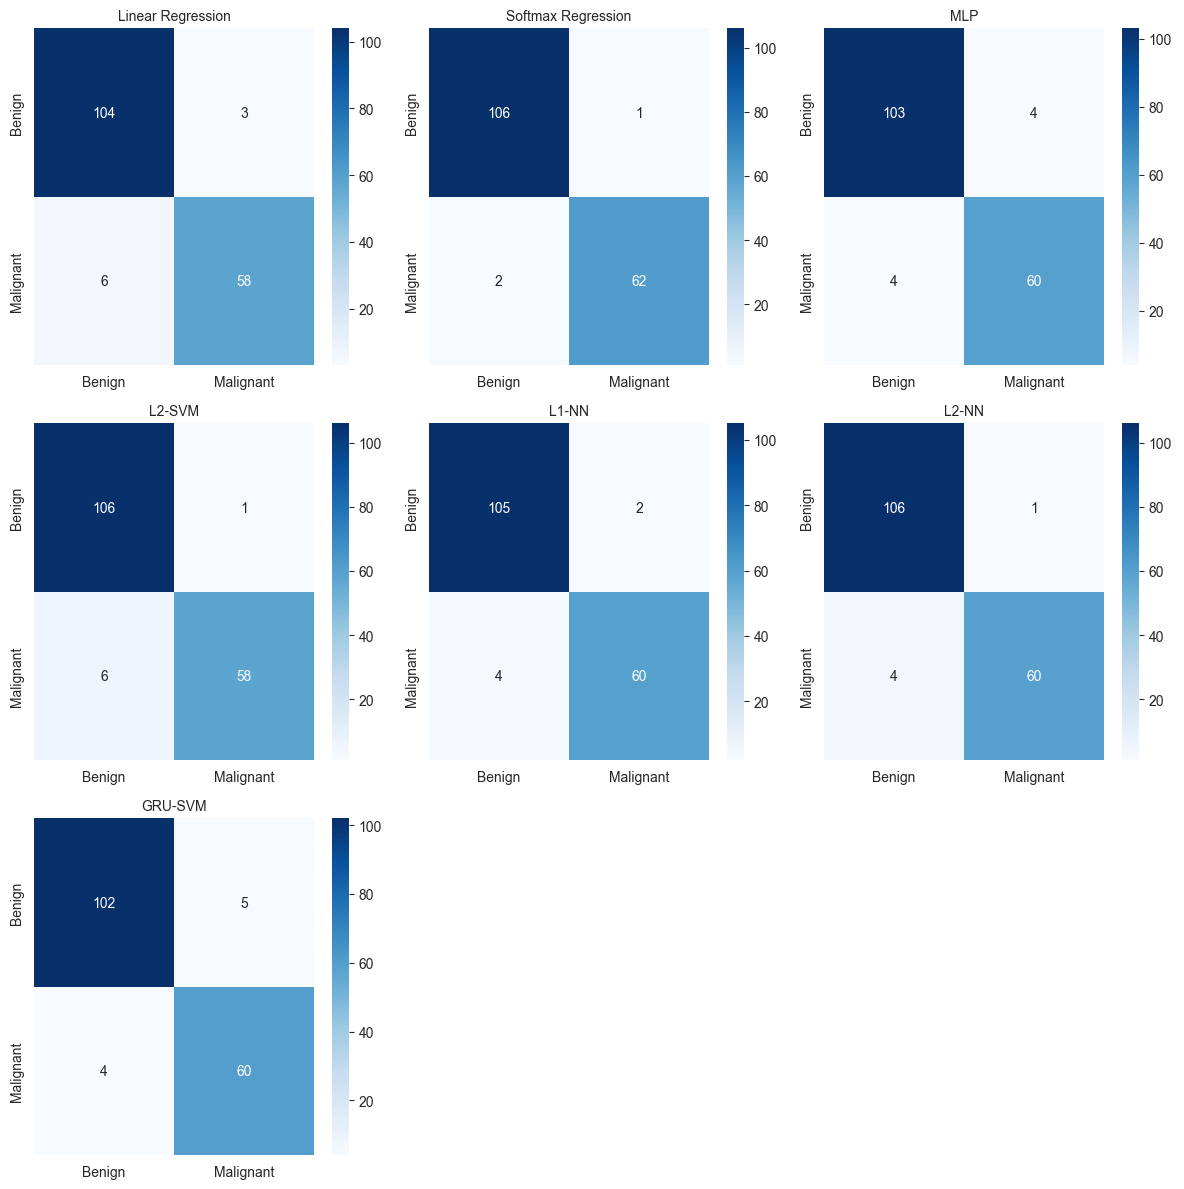

In [84]:
# =====================================================================
# 8. Matrices de confusion : visualisation détaillée des erreurs
# =====================================================================

# Liste des modèles et de leurs prédictions de classe sur le jeu de test.
# Chaque tuple contient : (nom lisible, vecteur y_pred correspondant).
models_data = [
    ('Linear Regression', lr_y_test_pred),
    ('Softmax Regression', softmax_y_test_pred),
    ('MLP', mlp_y_test_pred),
    ('L2-SVM', svm_y_test_pred),
    ('L1-NN', knn_l1_y_test_pred),
    ('L2-NN', knn_l2_y_test_pred),
    ('GRU-SVM', gru_svm_y_test_pred)
]

# Nombre total de modèles à afficher.
n_models = len(models_data)

# Disposition de la grille de sous-graphiques : 3 colonnes, n_rows lignes.
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols  # division plafond pour couvrir tous les modèles

# Création de la figure et des axes pour les heatmaps de matrices de confusion.
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))

# Gestion du cas où il n'y a qu'une seule ligne : axes peut être un seul axe ou un tableau.
if n_rows == 1:
    axes = axes if isinstance(axes, np.ndarray) else [axes]
else:
    axes = axes.flatten()  # mise à plat pour indexer simplement avec idx

# Boucle sur chaque modèle pour tracer sa matrice de confusion.
for idx, (name, y_pred) in enumerate(models_data):
    ax = axes[idx]  # axe courant

    # Matrice de confusion entre les vraies étiquettes y_test et les prédictions y_pred
    cm = confusion_matrix(y_test, y_pred)

    # Heatmap Seaborn de la matrice de confusion
    sns.heatmap(
        cm,
        annot=True,                    # affiche les nombres dans les cases
        fmt='d',                       # format entier
        cmap='Blues',                  # colormap bleue
        ax=ax,
        xticklabels=['Benign', 'Malignant'],  # labels de l'axe x
        yticklabels=['Benign', 'Malignant']   # labels de l'axe y
    )
    ax.set_title(name, fontsize=10)

# Si la grille contient plus d'axes que de modèles (cases vides), on les désactive.
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

# Ajuste automatiquement les espacements pour éviter le chevauchement des titres/étiquettes.
plt.tight_layout()
plt.show()

## 8.1 Courbes ROC des modèles

Nous traçons ici les courbes ROC de tous les modèles sur le jeu de test. Chaque courbe montre le compromis entre taux de vrais positifs (TPR) et taux de faux positifs (FPR), et l'aire sous la courbe (AUC) est indiquée dans la légende pour comparer visuellement les modèles.


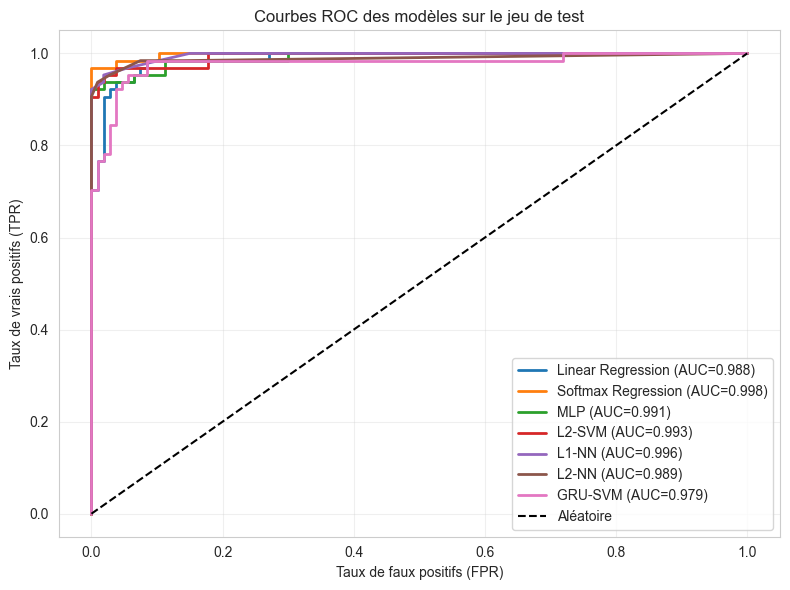

In [85]:
# =====================================================================
# 8.1 Courbes ROC des différents modèles sur le jeu de test
# =====================================================================

plt.figure(figsize=(8, 6))

# Dictionnaire des probabilités prédites pour la classe positive
probas = {
    'Linear Regression': lr_y_test_proba,
    'Softmax Regression': softmax_y_test_proba,
    'MLP': mlp_y_test_proba,
    'L2-SVM': svm_y_test_proba,
    'L1-NN': knn_l1_y_test_proba,
    'L2-NN': knn_l2_y_test_proba,
    'GRU-SVM': gru_svm_y_test_proba
}

# Boucle sur chaque modèle pour tracer sa courbe ROC
for name, y_proba in probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})", linewidth=2)

# Diagonale (classifieur aléatoire)
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire')

plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbes ROC des modèles sur le jeu de test')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 9. 📈 Courbes d'Apprentissage Détaillées

**Objectif** : Visualiser les courbes d'apprentissage pour tous les modèles, montrant l'évolution des performances selon la taille des données d'entraînement.

**Méthode** : Utilisation de `learning_curve` de scikit-learn pour tracer accuracy train/validation vs taille du dataset d'entraînement.

**Interprétation** :
- **Courbe qui monte** : Le modèle apprend avec plus de données
- **Écart train/validation** : Indique le potentiel d'overfitting
- **Plateau** : Performance maximale atteinte

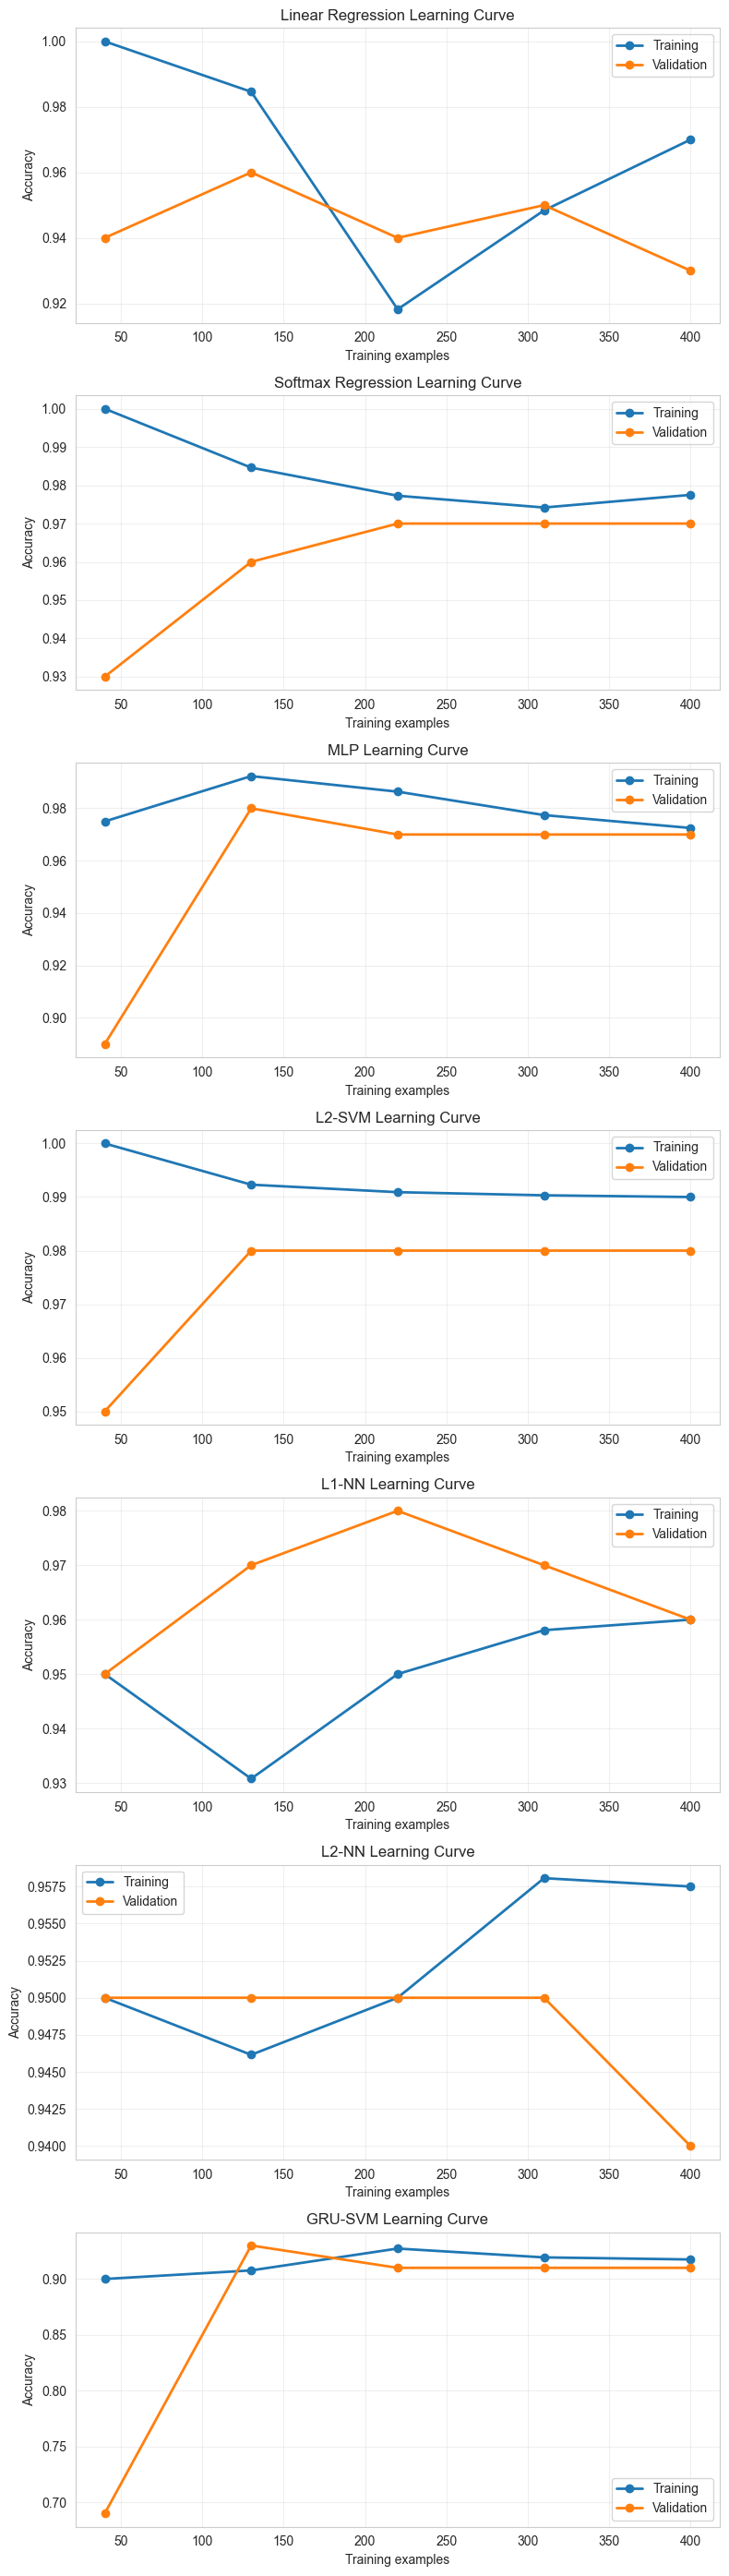

In [86]:
# =====================================================================
# 9. Courbes d'Apprentissage pour les modèles optimisés (Section 6)
# =====================================================================

from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.models import Model

# ---------------------------------------------------------------------
# Scorer personnalisé pour traiter la régression linéaire comme un classifieur
# ---------------------------------------------------------------------
def linear_reg_classifier_accuracy(y_true, y_pred_continuous):
    """Convertit les prédictions continues en classes binaires (seuil 0.5)."""
    y_pred = (y_pred_continuous >= 0.5).astype(int)
    return accuracy_score(y_true, y_pred)

linear_acc_scorer = make_scorer(linear_reg_classifier_accuracy)

# ---------------------------------------------------------------------
# Wrapper pour GRU-SVM compatible avec sklearn learning_curve
# ---------------------------------------------------------------------
class GRUSVMWrapper(BaseEstimator, ClassifierMixin):
    """Wrapper pour le modèle GRU-SVM compatible avec sklearn."""
    
    def __init__(self, gru_units=48, svm_C=1.0, random_state=42):
        self.gru_units = gru_units
        self.svm_C = svm_C
        self.random_state = random_state
        self.gru_model = None
        self.feature_extractor = None
        self.svm_model = None
    
    def fit(self, X, y):
        """Entraîne le modèle GRU-SVM."""
        from tensorflow.keras.regularizers import l2
        
        # Reshape pour GRU
        n_features = X.shape[1]
        X_gru = X.reshape(X.shape[0], n_features, 1)
        
        # 1. Entraînement du GRU
        self.gru_model = Sequential([
            Input(shape=(n_features, 1)),
            GRU(self.gru_units, return_sequences=False, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
            Dropout(0.5),
            BatchNormalization(),
            Dense(24, activation='relu', kernel_regularizer=l2(0.01)),
            Dropout(0.4),
            BatchNormalization(),
            Dense(1, activation='sigmoid')
        ])
        
        self.gru_model.compile(
            optimizer=Adam(learning_rate=5e-4),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            min_delta=1e-4,
            verbose=0
        )
        
        self.gru_model.fit(
            X_gru, y,
            epochs=300,
            batch_size=64,
            validation_split=0.2,
            verbose=0,
            callbacks=[early_stopping]
        )
        
        # 2. Extraction des features
        model_input = self.gru_model.layers[0].input
        self.feature_extractor = Model(
            inputs=model_input,
            outputs=self.gru_model.layers[-4].output
        )
        
        gru_features = self.feature_extractor.predict(X_gru, verbose=0)
        
        # 3. Entraînement du SVM
        self.svm_model = SVC(
            kernel='rbf',
            C=self.svm_C,
            gamma='scale',
            probability=True,
            random_state=self.random_state
        )
        self.svm_model.fit(gru_features, y)
        
        return self
    
    def predict(self, X):
        """Prédictions de classe."""
        n_features = X.shape[1]
        X_gru = X.reshape(X.shape[0], n_features, 1)
        gru_features = self.feature_extractor.predict(X_gru, verbose=0)
        return self.svm_model.predict(gru_features)
    
    def predict_proba(self, X):
        """Probabilités prédites."""
        n_features = X.shape[1]
        X_gru = X.reshape(X.shape[0], n_features, 1)
        gru_features = self.feature_extractor.predict(X_gru, verbose=0)
        return self.svm_model.predict_proba(gru_features)

# ---------------------------------------------------------------------
# Fonction pour tracer les courbes d'apprentissage
# ---------------------------------------------------------------------
def plot_learning_curve(estimator, X, y, title, scoring, cv, ax, n_jobs=-1):
    """Trace la courbe d'apprentissage (accuracy train/validation vs taille du dataset)."""
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=cv, scoring=scoring, n_jobs=n_jobs
    )
    train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
    val_mean, val_std = val_scores.mean(axis=1), val_scores.std(axis=1)
    
    ax.plot(train_sizes, train_mean, 'o-', label='Training', linewidth=2)
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
    ax.plot(train_sizes, val_mean, 'o-', label='Validation', linewidth=2)
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15)
    ax.set_title(title)
    ax.set_xlabel('Training examples')
    ax.set_ylabel('Accuracy')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

# ---------------------------------------------------------------------
# Recréation des modèles optimisés avec les meilleurs hyperparamètres
# ---------------------------------------------------------------------
# Note: Pour GRU-SVM, on utilise le wrapper avec les meilleurs hyperparamètres trouvés
gru_svm_C_value = best_gru_svm_C if 'best_gru_svm_C' in globals() and best_gru_svm_C is not None else 1.0

models_lc = [
    ('Linear Regression', SGDRegressor(loss='squared_error', learning_rate='constant', 
                                        eta0=best_eta, max_iter=best_iter, random_state=42), linear_acc_scorer),
    ('Softmax Regression', LogisticRegression(C=best_softmax_C, solver=best_softmax_solver, 
                                               max_iter=best_softmax_max_iter, random_state=42), 'accuracy'),
    ('MLP', MLPClassifier(hidden_layer_sizes=best_mlp_hidden, learning_rate_init=best_mlp_lr, 
                          learning_rate='adaptive', alpha=best_mlp_alpha, max_iter=best_mlp_it, 
                          batch_size=128, n_iter_no_change=20, early_stopping=True, 
                          random_state=42, validation_fraction=0.1), 'accuracy'),
    ('L2-SVM', SVC(C=best_svm_C, kernel='linear', probability=True, random_state=42), 'accuracy'),
    ('L1-NN', KNeighborsClassifier(n_neighbors=best_knn_l1_k, metric='minkowski', p=1), 'accuracy'),
    ('L2-NN', KNeighborsClassifier(n_neighbors=best_knn_l2_k, metric='minkowski', p=2), 'accuracy'),
    ('GRU-SVM', GRUSVMWrapper(gru_units=48, svm_C=gru_svm_C_value, random_state=42), 'accuracy')
]

# ---------------------------------------------------------------------
# Tracé des courbes d'apprentissage pour tous les modèles (sans cross-validation)
# ---------------------------------------------------------------------
# Utilisation d'un seul split train/validation au lieu de cross-validation
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
fig, axes = plt.subplots(len(models_lc), 1, figsize=(8, 4 * len(models_lc)))
if len(models_lc) == 1:
    axes = [axes]

for ax, (name, est, scoring) in zip(axes, models_lc):
    plot_learning_curve(est, X_train_smote, y_train_smote, f'{name} Learning Curve', scoring, cv, ax)

plt.tight_layout()
plt.show()

In [87]:
# =====================================================================
# 9.1 Identification du meilleur modèle
# =====================================================================

# Identification du modèle avec la meilleure accuracy sur le jeu de test
best_model = results_df['accuracy'].idxmax()
best_accuracy = results_df.loc[best_model, 'accuracy']
best_roc_auc = results_df.loc[best_model, 'roc_auc']

print(f"Meilleur Modèle : {best_model}")
print(f"  Accuracy sur Test : {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"  ROC-AUC : {best_roc_auc:.4f}")

print("\nTous les modèles ont dépassé le seuil de 90% d'accuracy :")
for model in results_df.index:
    acc = results_df.loc[model, 'accuracy']
    print(f"  {model}: {acc*100:.2f}%")

Meilleur Modèle : Softmax Regression
  Accuracy sur Test : 0.9825 (98.25%)
  ROC-AUC : 0.9978

Tous les modèles ont dépassé le seuil de 90% d'accuracy :
  Linear Regression: 94.74%
  Softmax Regression: 98.25%
  MLP: 95.32%
  L2-SVM: 95.91%
  L1-NN: 96.49%
  L2-NN: 97.08%
  GRU-SVM: 94.74%


In [88]:
best_model = results_df['accuracy'].idxmax()
best_accuracy = results_df.loc[best_model, 'accuracy']
best_roc_auc = results_df.loc[best_model, 'roc_auc']

print(f"Meilleur Modèle : {best_model}")
print(f"  Accuracy sur Test : {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"  ROC-AUC : {best_roc_auc:.4f}")

print("Tous les modèles ont dépassé le seuil de 90% d'accuracy :")
for model in results_df.index:
    acc = results_df.loc[model, 'accuracy']
    print(f"  {model}: {acc*100:.2f}%")

Meilleur Modèle : Softmax Regression
  Accuracy sur Test : 0.9825 (98.25%)
  ROC-AUC : 0.9978
Tous les modèles ont dépassé le seuil de 90% d'accuracy :
  Linear Regression: 94.74%
  Softmax Regression: 98.25%
  MLP: 95.32%
  L2-SVM: 95.91%
  L1-NN: 96.49%
  L2-NN: 97.08%
  GRU-SVM: 94.74%
